In [18]:
import meshzoo
import numpy as np
import igl
import meshplot as mp
import scipy.io
import os
import math
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
import matplotlib as mpl
from IPython.display import Image, display, Markdown
import ipywidgets as widgets
from meshplot_utils import add_transparent_mesh, color4plot, Out
#from utils.debug_utils import picture_table_with_title
import utils.debug_utils  as du
import utils.geometry  as gu
import glob
import fnmatch
#from auxilary.test_postprocessing import get_obj_files, get_obj_class_by_index, read_cad_mesh, clean_CAD_format, load_meshes_from_files
import auxilary.test_postprocessing as tp
clean_cad_formats =  False
import  meshplot_utils  as mu
from tabulate import tabulate

#reloading changes in moduls without restaring notebook 
import importlib
importlib.reload(mu)
importlib.reload(gu)
importlib.reload(tp)
import pickle

from tabulate import tabulate
from scipy.spatial.transform import Rotation as Rot

In [19]:
#configurations 
shading_dic = dict(wireframe=True, line_color= [0.2,0.2,0.2] )
resolutions= [2,3,4]

npy_file     = '../auxilary/icoshpere_meshes.npy'
npy_sub_file = '../auxilary/icoshpere_mesh_subdivision_1.npy'


#========================== small scale tests 10% ==================================
# data_path_list = ['../save/car_10_MRCNN_small/car_small-qualitative',\
#                   '../save/plane_car_1_PointRend_small/aeroplane_small-car_small-qualitative',\
#                   '../save/plane_car_2_PointRend_small/aeroplane_small-car_small-qualitative', \
#                   '../save/bicycle_bus_car_bike_1_PointRend_small/bicycle_small-bus_small-car_ small-motorbike_small-qualitative',\
#                   '../save/bicycle_bus_car_bike_4_PointRend_small/bicycle_small-bus_small-car_small-motorbike_small-qualitative' \
#                 ] 


#=============================full test datas ======================================
data_path_list = ['../save/car_10_MRCNN__/car-qualitative',  \
                 '../save/plane_car_1_PointRend__/aeroplane-car-qualitative', \
                 '../save/plane_car_2_PointRend__/aeroplane-car-qualitative', \
                 '../save/bicycle_bus_car_bike_1_PointRend__/bicycle-bus-car-motorbike-qualitative', \
                 '../save/bicycle_bus_car_bike_4_PointRend__/bicycle-bus-car-motorbike-qualitative' \
                ]


widgets.Checkbox(value=False,description='show initial shape')
  

#visualize_sphere = True 
sphere_data = []
#if visualize_sphere:
sphere_data = np.load(npy_sub_file, allow_pickle = True).item()
reflect_sphere_y = True #MCMR intializes shapes with eco-sphere reflected along y axis 
meshplot_to_html = True
show_sphere_bydefault = True
show_image_table = True #show input and rendered  rgb and mask images 

enable_index_symmetry     = True  #symmetry of sphere deformation 
enable_Hausdorff_symmetry = True   #symmetry of reconstructed mesh  (enable only one to avoid  plots being messed up)

In [20]:
#help functions
def get_bboxes(vert):
    m = np.min(vert, axis=0)
    ma = np.max(vert, axis=0)
    ma_half = np.max(vert, axis=0)
    ma_half[0] = (m[0]+ma_half[0])/2.0

    # Corners of the bounding box
    v_box = np.array([[m[0], m[1], m[2]], [ma[0], m[1], m[2]], [ma[0], ma[1], m[2]], [m[0], ma[1], m[2]],
                    [m[0], m[1], ma[2]], [ma[0], m[1], ma[2]], [ma[0], ma[1], ma[2]], [m[0], ma[1], ma[2]]])


    v_box_half = np.array([[m[0], m[1], m[2]], [ma_half[0], m[1], m[2]], [ma_half[0], ma_half[1], m[2]], [m[0], ma_half[1], m[2]],
                    [m[0], m[1], ma_half[2]], [ma_half[0], m[1], ma_half[2]], [ma_half[0], ma_half[1], ma_half[2]], [m[0], ma_half[1], ma_half[2]]])                  

    # Edges of the bounding box
    f_box = np.array([[0, 1], [1, 2], [2, 3], [3, 0], [4, 5], [5, 6], [6, 7], 
                      [7, 4], [0, 4], [1, 5], [2, 6], [7, 3]], dtype=np.int)
                      
    return v_box, v_box_half, f_box

def draw_bboxes(p, vert):
    v_box, v_box_half, f_box = get_bboxes(vert)
    
    id1 = p.add_edges(v_box, f_box, shading={"line_color": "black"})
    id2 = p.add_edges(v_box_half, f_box, shading={"line_color": "black",'line_width':0.3})
    id3 = p.add_edges(v_box, np.array([[0, 1]],dtype=np.int), shading={"line_color": "red",'line_width':1})
    id4 = p.add_edges(v_box, np.array([[0, 3]],dtype=np.int), shading={"line_color": "green",'line_width':1})
    id5 = p.add_edges(v_box, np.array([[0, 4]],dtype=np.int), shading={"line_color": "blue",'line_width':1})
    
    return [id1,id2,id3,id4,id5]

sphere_plot_ids = []
def get_sphere(V):
    res = 0
    #print(f'(V,F): {(V.shape,F.shape)}')
    for i in sphere_data.keys():
        #print((sphere_data[i]['V'].shape, sphere_data[i]['F'].shape))
        if sphere_data[i]['V'].shape[0] ==V.shape[0] and sphere_data[i]['F'].shape[0] == F.shape[0] and  not np.any(sphere_data[i]['F'] - F):
            print(f"resolution level={i}")
            res = i
            break

    S = sphere_data[res]
    sphere_size = S['V'][:,0].max() - S['V'][:,0].min()
    shape_scale = V[:,0].max() - V[:,0].min()
    #SV = (S['V']/sphere_size)*shape_scale + np.array( [V[:,0].max() + shape_scale, 0, 0]) #normlaize to mesh size and shift left 
    SV = (S['V']/sphere_size)*shape_scale #normlaize to mesh size and shift left 
    if reflect_sphere_y:
        SV[:,1] = -SV[:,1]
    #sphere_plot_ids.append(p.add_mesh(SV,S['F'], shading = shading_dic))
    return SV, S['F']

def Out(str):
    display(Markdown(f'### {str}'))


def rotate_vec_list(V_list, axis=np.array([0,1,0]), angle =0.5*math.pi):
  rot = Rot.from_rotvec(angle* axis)
  V_rot_list = []
  for V in V_list:
    V_rot_list.append(rot.apply(V))
  return V_rot_list


In [21]:
def Visualize_Hausdorff_Outlier(V, F , V_sym, V_cad, F_cad, col_space=1.5, \
                                viewpoints =[ (np.array([0,1,0]), 0 ), (np.array([0,1,0]), -0.5*math.pi ) ],\
                                point_shading = dict(line_color='black', point_size = 0.3, connect_points=True) ):

  orig_col = [0.7,0.7,0.7]
  symm_col = [0,1,0]
  cad_col = [1,1,0]


  orig_max_col = 1 - np.array(orig_col)
  symm_max_col = 1 - np.array(symm_col)
  cad_max_col  = 1 - np.array(cad_col )
    
  mesh2CAD_dist, mesh_max2CAD, mesh2CAD_max =  gu.HaussdorffDistancePairs(V, F, V_cad, F_cad)
  mesh2CAD_pair   = np.row_stack((mesh_max2CAD,mesh2CAD_max))
  mesh2CAD_col    = np.row_stack((orig_max_col,cad_max_col))
  
  mesh_max2CAD = np.row_stack((mesh_max2CAD,mesh_max2CAD)) #DrawMeshes needs atleas two highlighed points 
  mesh2CAD_max = np.row_stack((mesh2CAD_max,mesh2CAD_max))
   
  #print(f'(new col, orig col) = { (mesh2CAD_col,orig_max_col)}')

  mesh_sym2CAD_dist, mesh_sym_max2CAD, mesh_sym2CAD_max =  gu.HaussdorffDistancePairs(V_sym, F, V_cad, F_cad)
  mesh_sym2CAD_pair     = np.row_stack((mesh_sym_max2CAD,mesh_sym2CAD_max))
  mesh_sym2CAD_col =    np.row_stack((symm_max_col,cad_max_col))

  mesh_sym_max2CAD = np.row_stack((mesh_sym_max2CAD,mesh_sym_max2CAD)) #DrawMeshes needs atleas two highlighed points 
  mesh_sym2CAD_max = np.row_stack((mesh_sym2CAD_max,mesh_sym2CAD_max))
  print('Recheck improvements in distances')
  print(f'  Mesh-CAD hasdourff = {mesh2CAD_dist},  Symmetric_mesh-CAD hasdourff={mesh_sym2CAD_dist}, Improvments = {100*(mesh2CAD_dist - mesh_sym2CAD_dist)/mesh2CAD_dist} %')
  mesh2CAD_dist_rel    = mesh2CAD_dist    / (V.max() - V.min())
  mesh_sym2CAD_dist_rel= mesh_sym2CAD_dist/ (V_sym.max() - V_sym.min())
  print(f'  Mesh-CAD relative= {mesh2CAD_dist_rel},   Symmetric_mesh-CAD relative= {mesh_sym2CAD_dist_rel}, Improvments relative= {100*(mesh2CAD_dist_rel - mesh_sym2CAD_dist_rel)/mesh2CAD_dist} %')
  

  shading_wf  = dict(wireframe=True, line_color= [0.1,0.1,0.1], width=1000, height=1000, wire_width=0.01, flat=True, line_width=0.01)
  shading     = shading_wf.copy()
  shading['wireframe'] = False
  #shadings = [shading_wf, shading, shading_wf, shading, shading, shading]
  shadings = [shading] * 6


  mesh_list = []

  for vp in viewpoints:
    V_, mesh2CAD_pair_, V_sym_, mesh_sym2CAD_pair_,  V_cad_  = rotate_vec_list(
    [V, mesh2CAD_pair,  V_sym,  mesh_sym2CAD_pair,   V_cad ] , vp[0], vp[1]
    )
    mesh2sym_pair = np.row_stack( (mesh2CAD_pair_[0,:],mesh_sym2CAD_pair_[0,:]) )
    mesh2sym_col  = np.row_stack( (mesh2CAD_col[0,:],  mesh_sym2CAD_col[0,:])   )

    mesh_list +=  [ mu.StackMeshes( [ [V_,   F,  orig_col+[.6],   mesh2CAD_pair_,     mesh2CAD_col     ],     [V_cad_, F_cad, cad_col+[.6]  ]  ]), \
                    mu.StackMeshes( [ [V_sym_, F,  symm_col+[.6], mesh_sym2CAD_pair_, mesh_sym2CAD_col  ],     [V_cad_, F_cad, cad_col+[.6] ]  ]), \
                    mu.StackMeshes( [ [V_,     F,  orig_col+[.6], mesh2sym_pair,     mesh2sym_col ],          [V_sym_, F,    symm_col+[.6] ]   ]),  \
                  ] 

  nrow = len(viewpoints)
  mesh_table = mu.MeshList2Table(mesh_list, nrow, 3, copy_elements =True) #deesn't work without  'copy_elements' because  mesh_list elements point several time  to the same mesh  
  mu.DrawMeshTable(None,mesh_table, col_shift=np.array([col_space, col_space, 0]),\
                                        row_shift = -1.3, mesh_shading = nrow*shadings,  point_shading = point_shading )

# Analysing 3D metric results obtained from NEW  version of loss preprocessing 
*  metric histograms 
*  best/worst outliners 
*  visualizng best worst cases 

### Analysing best symmetrization w.r.t Hausdorff (id) (anchor_index = 8 )

test_name=['plane_8_MRCNN__', 'plane_car_2_PointRend__', 'Pascal3D_12_classes_1_PointRend__', 'Pascal3D_12_classes_12_PointRend__']

 =================== Improvements achieved by selecting  Best Symmetrization per Sample  per metric (%) =====================
----------------------------------  -------------------  ------------------  -------------------  ------------------  ------------------  --------------------  ------------------  ------------------  ------------------
test                                L1 Metric            FID Metric          1 - SSIM             Texture Comb        SSL Comb            Total Loss            1-IoU_3D            1-IoU_3D (id)       Hausdorff (id)
plane_8_MRCNN__                     1.0377122797612217   2.563816996702748   0.9699721469906734   1.0073548380624127  0.5021260093881876  0.7391326539621078    2.0389019541180384  1.2400000578999286  2.689038200742866
plane_car_2_PointRend__             0.17813526271189462  3.3296093832288083  0.3304482981

### test number 0, number of samples = (266, 9), number of meshes =266

###   best    symmetrization =  [4.90057923e-02 3.07758169e+02 1.94931330e-01 9.97677725e-01
 1.74097680e+00 1.17801635e+01 3.05613656e-01 2.98074338e-01
 2.14576589e-01]

###       mean improvements = (array([1.0457585 , 2.91570042, 0.92288918, 1.12065595, 0.60146373,
       0.76497415, 2.07750854, 1.28256355, 2.45734576]), array([1.03771228, 2.563817  , 0.96997215, 1.00735484, 0.50212601,
       0.73913265, 2.03890195, 1.24000006, 2.6890382 ])) %

### Drawing histograms

writting ../debug/plots/plane_8_MRCNN__.png


### Drawing histograms

writting ../debug/plots/plane_8_MRCNN__.png


### Drawing histograms

writting ../debug/plots/plane_8_MRCNN__.png


### Drawing histograms

writting ../debug/plots/plane_8_MRCNN__.png


### test number 1, number of samples = (477, 9), number of meshes =477

###   best    symmetrization =  [5.89517856e-02 3.24110881e+02 2.49109814e-01 1.16591764e+00
 1.83906901e+00 1.19571267e+01 4.86259165e-01 4.49025582e-01
 1.67954243e-01]

###       mean improvements = (array([0.26181243, 3.45204593, 0.2676626 , 0.9031092 , 0.44326768,
       0.15442465, 1.23789372, 0.67017101, 2.87574833]), array([ 0.17813526,  3.32960938,  0.3304483 ,  0.96737972,  0.3932942 ,
       -0.32661225,  1.46892698,  0.87918342,  2.79206042])) %

### Drawing histograms

writting ../debug/plots/plane_car_2_PointRend__.png


### Drawing histograms

writting ../debug/plots/plane_car_2_PointRend__.png


### Drawing histograms

writting ../debug/plots/plane_car_2_PointRend__.png


### Drawing histograms

writting ../debug/plots/plane_car_2_PointRend__.png


### test number 2, number of samples = (1856, 9), number of meshes =1856

###   best    symmetrization =  [8.84222424e-02 3.43538765e+02 3.41903569e-01 1.57446972e+00
 2.45172120e+00 2.01201314e+01 3.91354954e-01 3.69970806e-01
 2.51592516e-01]

###       mean improvements = (array([0.61297206, 3.59005066, 0.36674733, 0.92498238, 0.66568066,
       0.70863948, 1.30461917, 0.6789987 , 1.40003835]), array([0.65426447, 3.53386392, 0.42234261, 1.03203309, 0.71589263,
       0.87476446, 1.91534769, 0.87146531, 1.4490528 ])) %

### Drawing histograms

writting ../debug/plots/Pascal3D_12_classes_1_PointRend__.png


### Drawing histograms

writting ../debug/plots/Pascal3D_12_classes_1_PointRend__.png


### Drawing histograms

writting ../debug/plots/Pascal3D_12_classes_1_PointRend__.png


### Drawing histograms

writting ../debug/plots/Pascal3D_12_classes_1_PointRend__.png


### test number 3, number of samples = (1856, 9), number of meshes =1856

###   best    symmetrization =  [8.59315378e-02 3.33573994e+02 3.37268994e-01 1.53453233e+00
 2.37875856e+00 1.89926647e+01 4.06440665e-01 3.92486849e-01
 2.21408833e-01]

###       mean improvements = (array([0.47404025, 3.24246774, 0.33509708, 0.77794574, 0.54350573,
       0.56642687, 1.12948069, 0.55648555, 1.30795146]), array([0.52467463, 3.23105209, 0.37889721, 0.90652025, 0.61956754,
       0.73625069, 1.56077409, 0.83877477, 1.55276449])) %

### Drawing histograms

writting ../debug/plots/Pascal3D_12_classes_12_PointRend__.png


### Drawing histograms

writting ../debug/plots/Pascal3D_12_classes_12_PointRend__.png


### Drawing histograms

writting ../debug/plots/Pascal3D_12_classes_12_PointRend__.png


### Drawing histograms

writting ../debug/plots/Pascal3D_12_classes_12_PointRend__.png


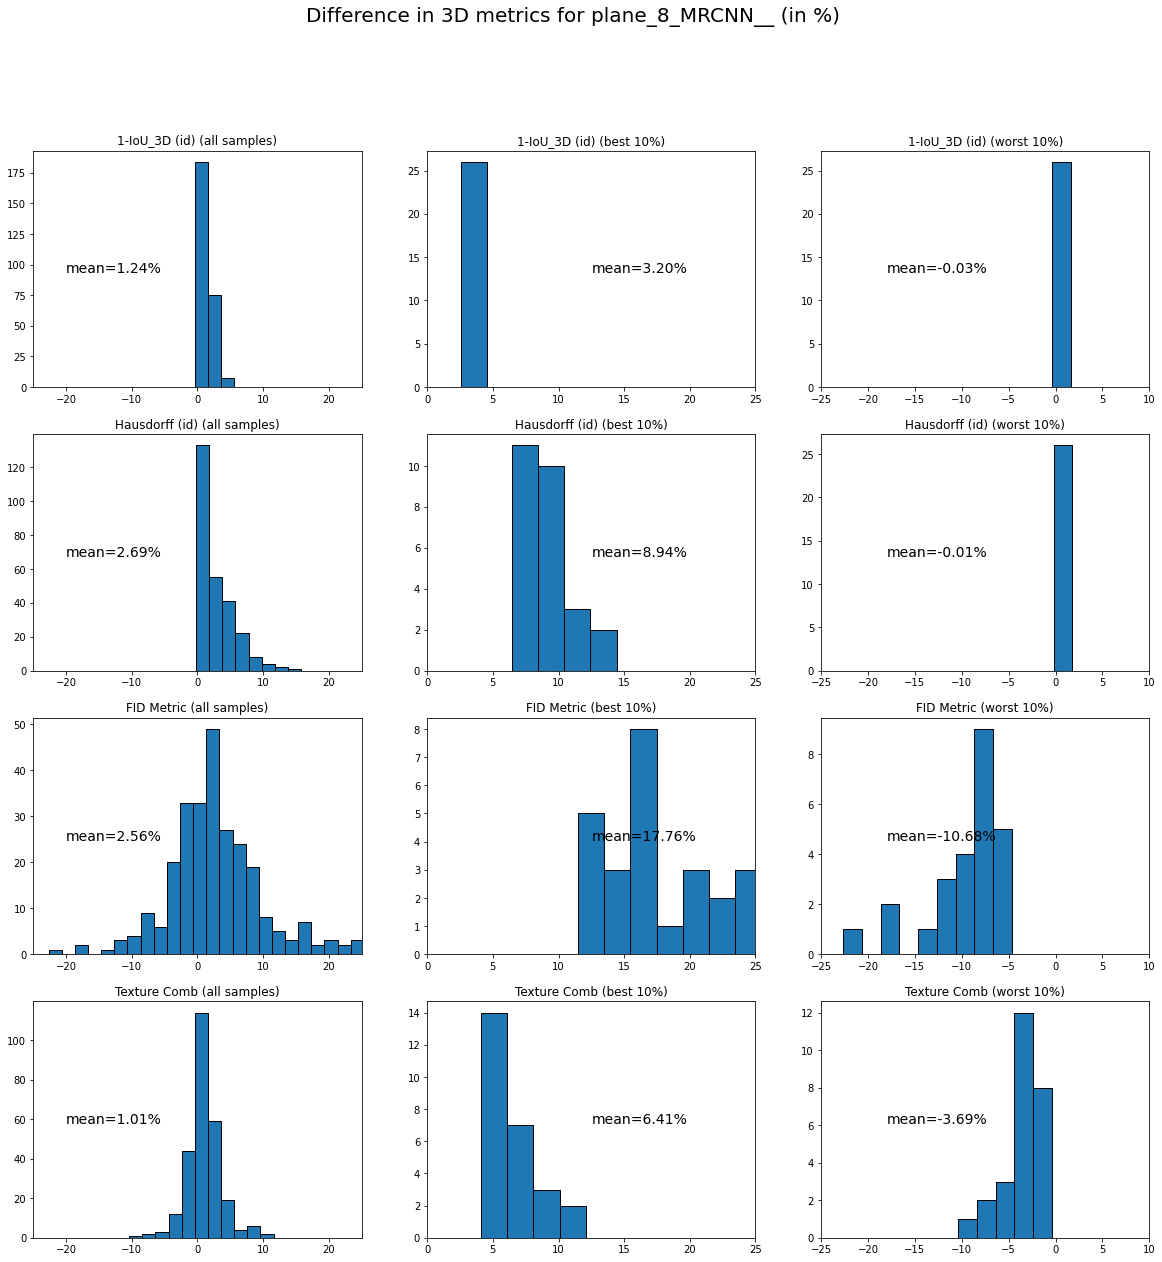

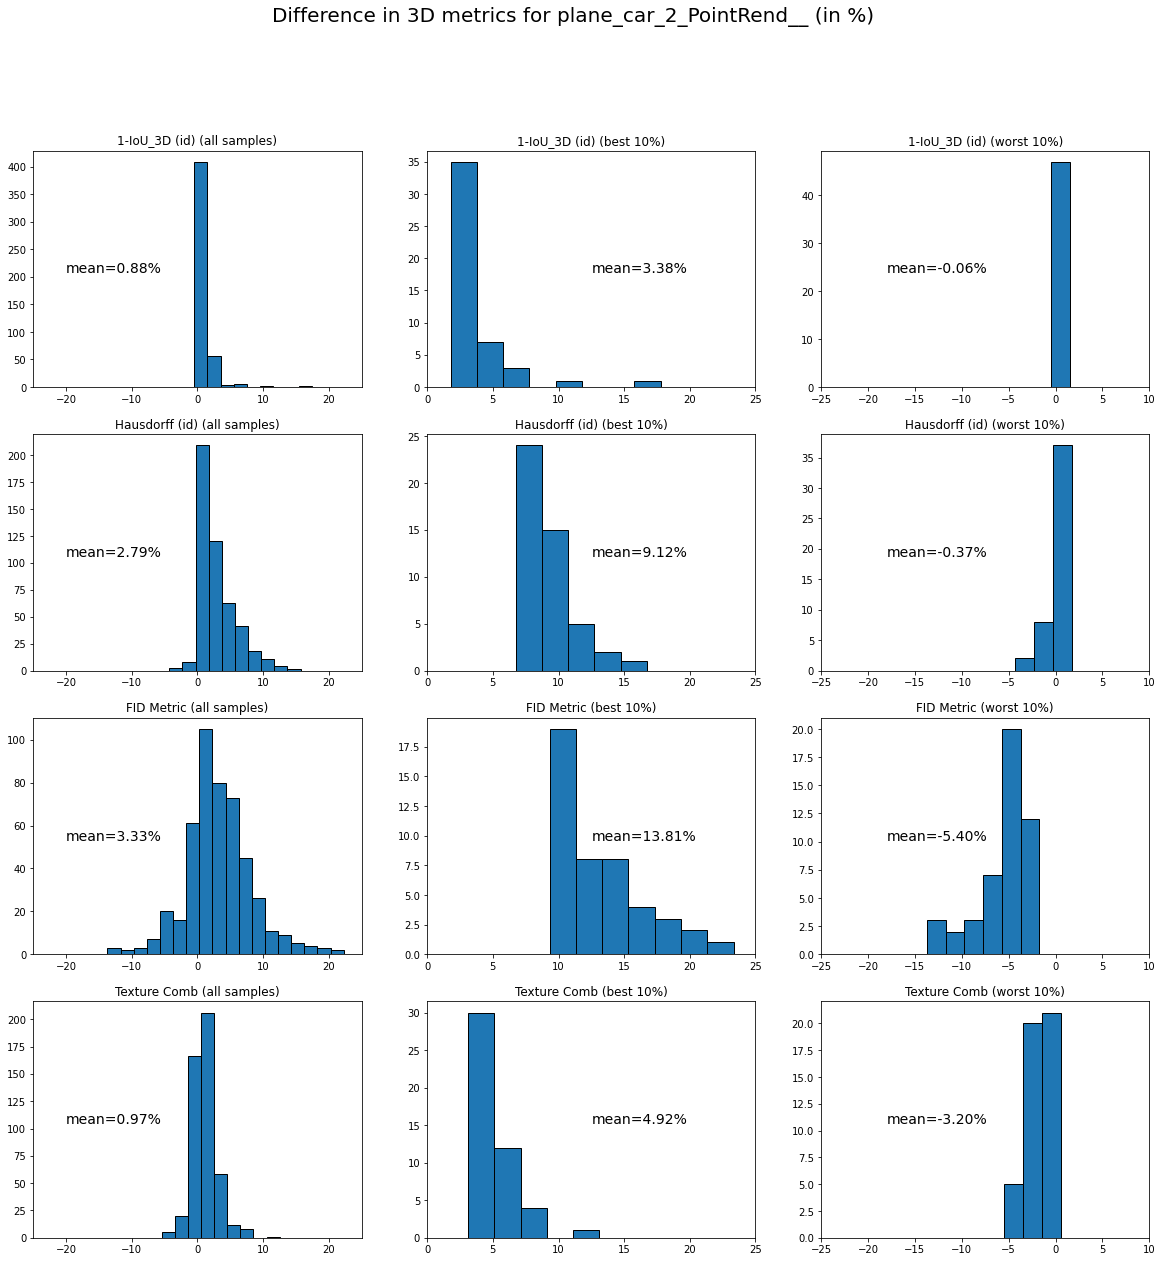

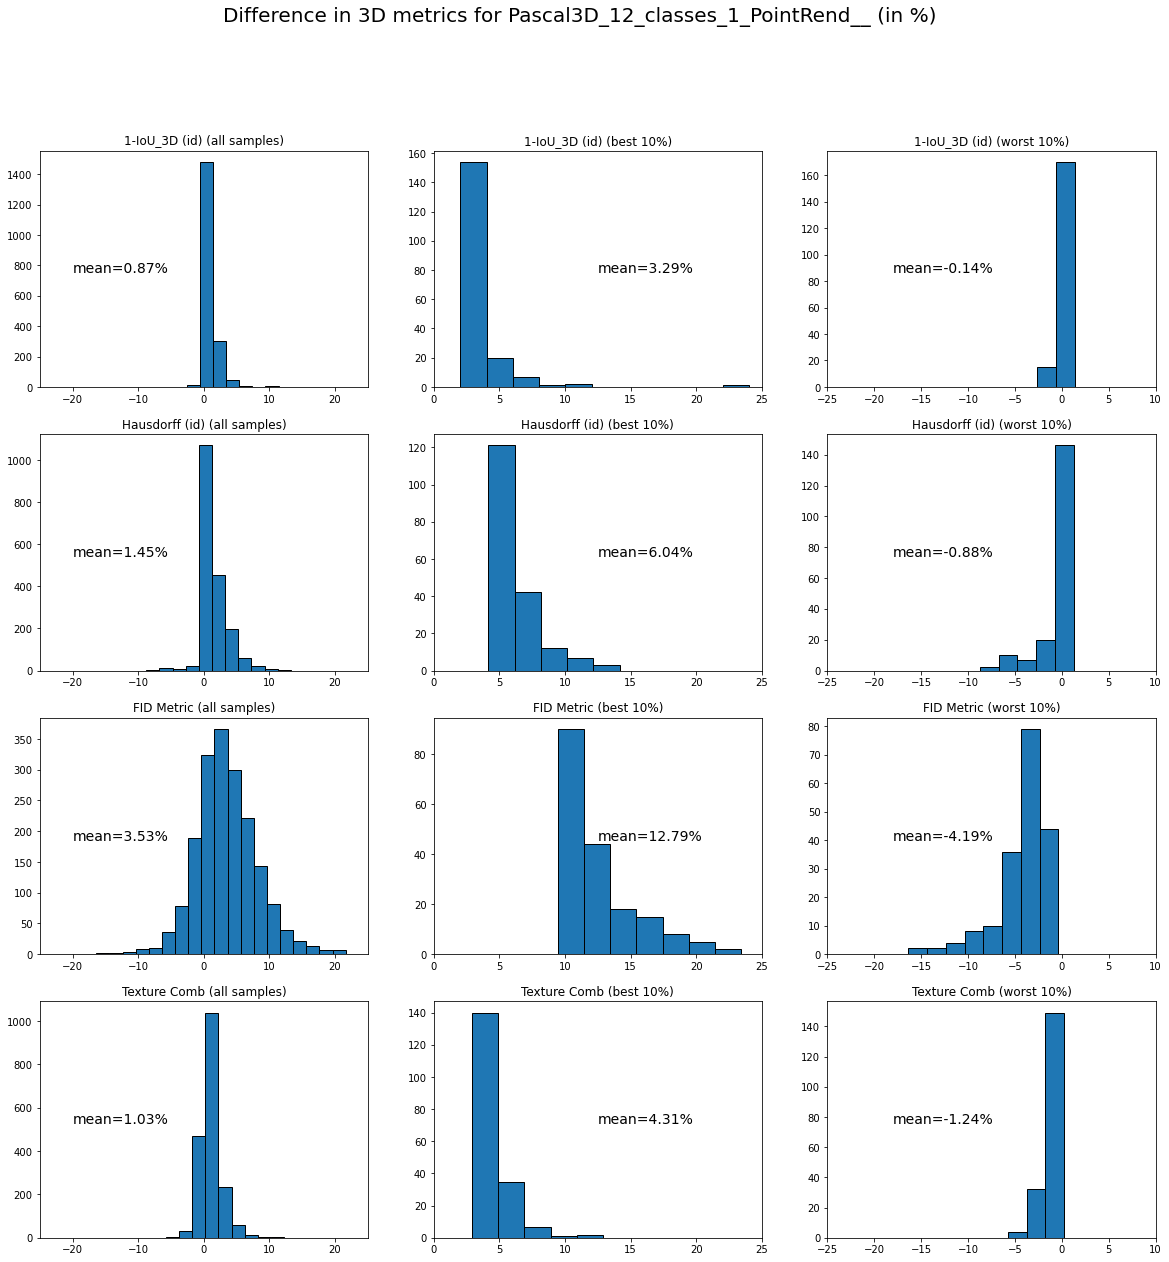

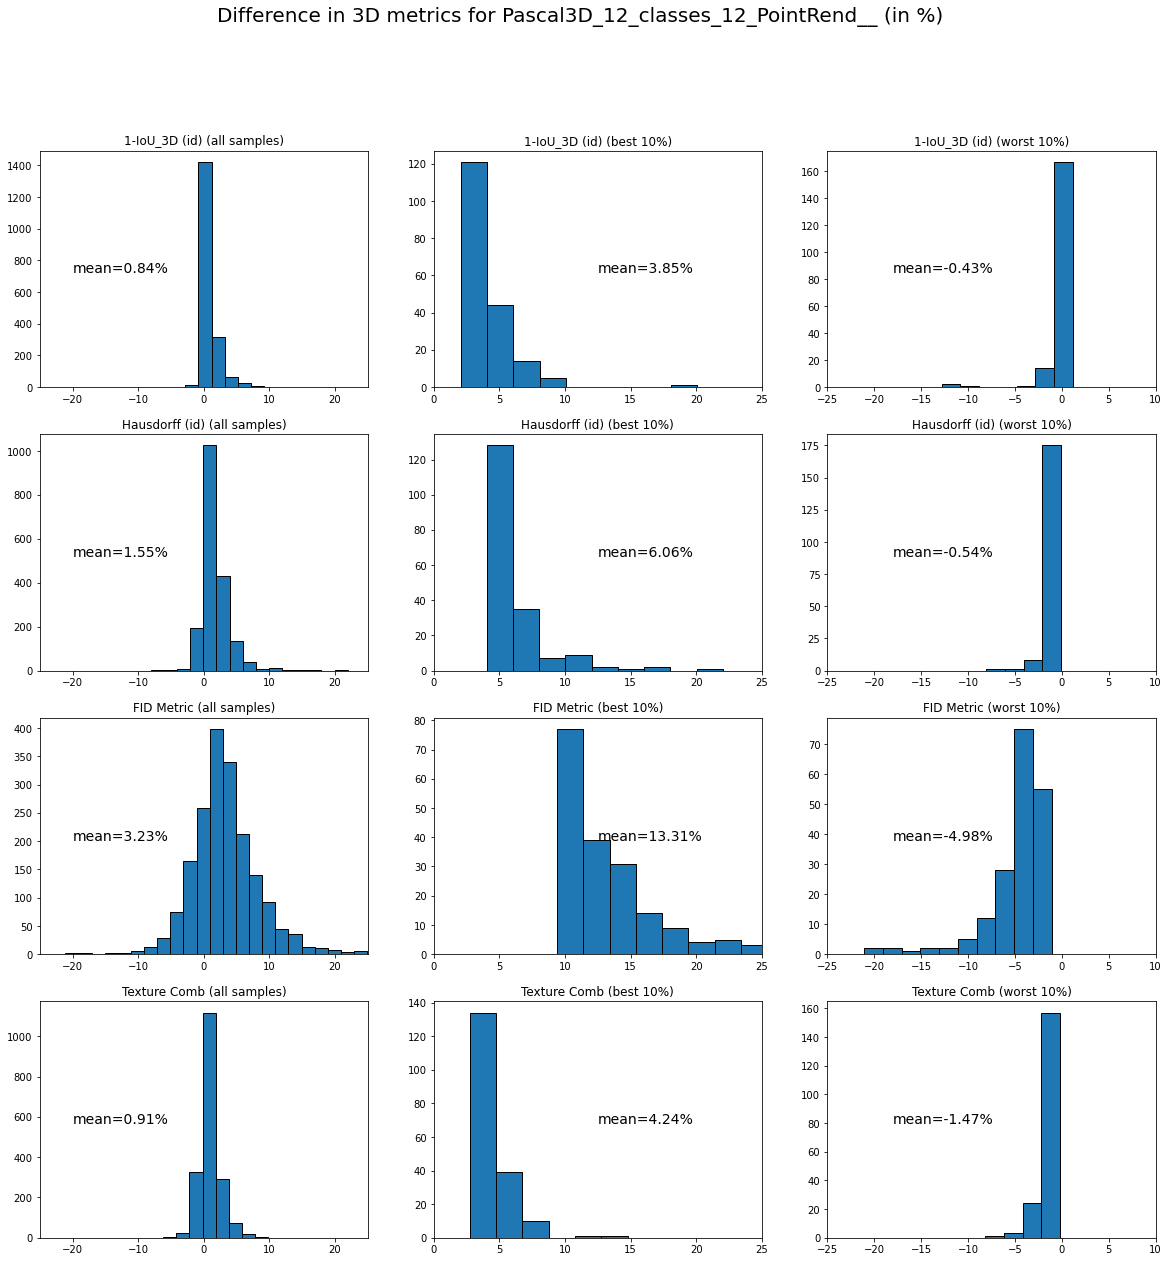

In [8]:
# # main loop to get histograms and drawing 
#shortenPath =  lambda path: '/'.join(path.split('/')[-3:-1]).replace('/', '.') #simple version of path to test name  
shortenPath =  lambda path: path.split('/')[1] #simple version of path to test name  
bool2String =  lambda b: ['without', 'with'][int(b)]

resume_pkl= '../save/post_processing.pkl'
with open(resume_pkl, 'rb') as handle:    experiment_data = pickle.load(handle)

reportOrig              = experiment_data['reportOrig']
reportSymmBest          = experiment_data['reportSymmBest']
reportSymmBestPerMetric = experiment_data['reportSymmBestPerMetric']
reportSymmConst         = experiment_data['reportSymmConst']

anchor_metric_names   = experiment_data['anchor_metric_names']
anchor_metric_indices = experiment_data['anchor_metric_indices']
metric_names          = experiment_data['metric_names']
result_path_list      = experiment_data['result_path_list']
symmNames             = experiment_data['symmNames']

reportImprovemetns = du.MetricReport(metric_names)
metric_num = len(metric_names)

#for ti in range(len(result_path_list)):
#V_symm = {}
V_meshes_worst = {}
metrics_worst  = {}
F_meshes_worst = {}
V_meshes_best  = {}
metrics_best   = {}
F_meshes_best  = {}


#3d configurations 
opt = gu.transformation_options(iter_num=10, sample_num = 2000, voxel_num =100,  enable_rescale = False, verbose =False)
opt.rewrite = False
#print(opt)
pipeline_opt = gu.pipeline_options(enable_icp=False)
pipeline_opt.IoU_3D_func  = gu.OneMinus3DIoU_fast
symmTypesDict             = {0:'orig',1:'l2r', 2:'r2l', 3:'cent'}
#print(pipeline_opt)

metric_3D_names = ['1-IoU_3D', 'Hausdorff', "max_mean", "mean_mean"] 
anchor_metric_name  =  'Hausdorff'
anchor_3D_metric_index = metric_3D_names.index(anchor_metric_name)
if not(pipeline_opt.enable_icp):
    anchor_metric_name += ' (id)'
anchor_metric_index = metric_names.index(anchor_metric_name)
Out(f'Analysing best symmetrization w.r.t {anchor_metric_name} (anchor_index = {anchor_metric_index} )')
#reportSymm = reportSymmBest[ anchor_metric_index ]
reportSymm = reportSymmBestPerMetric

test_name = [shortenPath(p) for p in result_path_list]
print(f'test_name={test_name}')

# ============> Histogram Settings  <========================
Range           = [-25, 25]
outlier_percent = 10
enable_hausdorff_recheck = False
histogram_metrics = ['1-IoU_3D', 'Hausdorff', 'FID Metric','Texture Comb']

reportOrig.compare(reportSymmBestPerMetric, f"\n =================== Improvements achieved by selecting  Best Symmetrization per Sample  per metric (%) =====================")[0]

#for ti in [0,1,2,3]:
for ti in range(len(result_path_list)):
    result_path = result_path_list[ti]
    #should be "non-symmetric" path to get non symmetric obj files, otherwise symmetrization won't have any impact
    pkl_files  = glob.glob(f'{"../"+result_path}-non_symmetric/*/test_results.pkl') 
    #print(pkl_files)
    data_path = os.path.split(pkl_files[0])[0]
    mesh_files, cad_files = get_mesh_cad_file_pairs([data_path], CAD_path)

    metrics_report     = reportOrig.metrics_list[ti]
    metric_symm_report = reportSymm.metrics_list[ti]
    Out(f'test number {ti}, number of samples = {metric_symm_report.shape}, number of meshes ={len(mesh_files)}')
    Out(f"  best    symmetrization =  {metric_symm_report.mean(axis=0)}")


    
    mesh_files = du.List(mesh_files)
    cad_files  = du.List(cad_files)
    improvment =  100*(metrics_report - metric_symm_report ) / metrics_report
    metrics_mean_report = metrics_report.mean(axis=0).tolist()
    mean_improvment =  (metrics_mean_report - metric_symm_report.mean(axis=0)) / metrics_mean_report
    reportImprovemetns.add_test(test_name[ti], np.array(improvment))
    Out(f"      mean improvements = {(100*mean_improvment,improvment.mean(axis=0))} %")
   

    fig, axs = plt.subplots(len(histogram_metrics), 3, figsize=(20,20) )
    fig.suptitle(f'Difference in 3D metrics for {test_name[ti]} (in %)', fontsize=20)

    sample_num = metrics_report.shape[0]
    Vsym_meshes =[]
    Vcad_meshes =[]
    Fcad_meshes =[]
    
    symmetry_data = np.load( data_path + '/shape_symmetries.npy', allow_pickle = True).item() #symmetry data is the same for all classes 
    opt.symmetry_data = symmetry_data
    metric_num = len(reportSymm.metric_names)

       
    ######### for beings  ##################################################################
    
    #histogram_metrics = ['Hausdorff']
    for j in range(len(histogram_metrics)):

        hist_name = histogram_metrics[j]
        #mi_3d = metric_3D_names.index(hist_name)
        if hist_name in metric_3D_names and not(pipeline_opt.enable_icp):
            hist_name += ' (id)'
        mi = metric_names.index(hist_name)
 
        name  =reportSymm.metric_names[mi]
        data = improvment[:,mi] # here I'm using the decreasing "1-3D IoU" !!
        #data = improvment[:,mi] if mi  else -improvment[:,mi] # 3D IoU goes in differnt direction


        w=2
        #histogram 
        axs[j,0].hist(data, edgecolor='black', bins=np.arange(min(data), max(data) + w, w)) 
        axs[j,0].title.set_text(f'{name} (all samples)')
        axs[j,0].set_xlim(Range)
        axs[j,0].text(0.1, 0.5, f'mean={data.mean():.2f}%', horizontalalignment='left',  verticalalignment='center', transform =  axs[j,0].transAxes, fontsize=14)

        
        #computing outlier sampled w.r.t metric "mi"
        outlier_num = int(outlier_percent/100*sample_num)
        
        sorted_indices   = np.argsort(data)
        worst_indices    = sorted_indices[:outlier_num]
        data_worst       = data[ worst_indices ]
        worst_mesh_files = mesh_files[worst_indices]
        worst_cad_files  = cad_files[worst_indices]
        

        best_indices     = sorted_indices[-outlier_num:]
        data_best        = data[best_indices]
        best_mesh_files  = mesh_files[best_indices]
        best_cad_files   = cad_files[best_indices]
        
        Out('Drawing histograms')
        axs[j,1].hist(data_best, edgecolor='black', bins=np.arange(min(data_best), max(data_best) + w, w)) 
        axs[j,1].title.set_text(f'{name} (best {outlier_percent}%)')
        axs[j,1].set_xlim([0,Range[1]])
        axs[j,1].text(0.5, 0.5, f'mean={data_best.mean():.2f}%', horizontalalignment='left',  verticalalignment='center', transform =  axs[j,1].transAxes, fontsize=14)
        axs[j,2].hist(data_worst, edgecolor='black', bins=np.arange(min(data_worst), max(data_worst) + w, w)) 
        axs[j,2].title.set_text(f'{name} (worst {outlier_percent}%)')
        axs[j,2].set_xlim([Range[0], 10])
        axs[j,2].text(0.2, 0.5, f'mean={data_worst.mean():.2f}%', horizontalalignment='left',  verticalalignment='center', transform =  axs[j,2].transAxes, fontsize=14)
        fig_file = f'../debug/plots/{test_name[ti]}.png'
        fig.savefig(fig_file)
        print(f'writting {fig_file}')

        #################################################################
        #Further analysis for Hausdorff  metric only 
        if histogram_metrics[j] !=  'Hausdorff' or not(enable_hausdorff_recheck): 
            continue
        Out(F"Recheck results for Hausdorff {bool2String(pipeline_opt.enable_icp)} ICP")
        _, F_meshes_worst    = tp.load_meshes_from_files(worst_mesh_files)
        Vcad_meshes_worst, Fcad_meshes_worst = tp.load_meshes_from_files(worst_cad_files)

        _, F_meshes_best    = tp.load_meshes_from_files(best_mesh_files)
        Vcad_meshes_best, Fcad_meshes_best = tp.load_meshes_from_files(best_cad_files)

        metrics_worst ={}
        metrics_best  ={}
        for symm_type, symm_name in symmTypesDict.items():
            pipeline_opt.symmetrization_type = symm_type
            metrics_worst[symm_name], V_meshes_worst[symm_name] = tp.compute_3d_metrics(worst_mesh_files, worst_cad_files, opt, pipeline_opt)
            metrics_best[symm_name],  V_meshes_best[symm_name]  = tp.compute_3d_metrics(best_mesh_files,  best_cad_files, opt,  pipeline_opt)

        for metrics, ii, outlier_type in [(metrics_worst,0,'worst'), (metrics_best,-1,'best')]: 

            metrics_symm     = np.stack(list(metrics.values()) ,axis=2) #stack metrics from all k symmetrization into  N*K matrix
            metrics['best']       = metrics_symm.min(axis=-1)
            metrics['best_type']  = np.argmin(metrics_symm,axis=-1)
            metrics['worst']      = metrics_symm.max(axis=-1)
            metrics['worst_type'] = np.argmax(metrics_symm,axis=-1)
            

            print(f'metic_names={metric_names}')
            Out(f'Analyse {outlier_type} cases for metric {metric_names[mi]} ')
            #ii = 0
            symmNames = [*symmTypesDict.values()]#names of differnet symmetrization types 

            metric_table =  tabulate( [ ['Type']  + metric_3D_names] + \
                                    [[name] +   metrics[name][ii].tolist() for name in symmNames], \
                                    headers="firstrow" )

            print(metric_table)
            Out('Mesh-to CAD distance Improvments in %')
            metric_improvment =  tabulate( [ ['Type'] + metric_3D_names ] + \
                                        [ [name] + (100*(metrics['orig'][ii]- metrics[name][ii])/metrics['orig'][ii]).tolist()  for name in symmNames[1:] ], \
                                        headers="firstrow" )
            print(metric_improvment)
        


        # =================================================================
        #           3D plot of outliers with highlighet points 
        #print(f'symmTypesDict.values()={symmTypesDict.values()}, worst_symm_type_index={worst_symm_type_index}')
        mi_3d = metric_3D_names.index(histogram_metrics[j])
        ii = 0
        #symm_type_name = 'r2l'
        worst_symm_type_index =  metrics_worst['worst_type'][ii,mi_3d]
        worst_symm_type_name = list(symmTypesDict.values())[worst_symm_type_index]
        mu.Out(f'visualizing the worst Husdorff sample for symmetrization of  type = {worst_symm_type_name}')
        wF      = F_meshes_worst[ii]
        wF_cad  = Fcad_meshes_worst[ii]
        wV      = V_meshes_worst['orig'][ii]
        wV_sym  = V_meshes_worst[worst_symm_type_name][ii]
        wV_cad =  Vcad_meshes_worst[ii]
        Visualize_Hausdorff_Outlier(wV,wF, wV_sym, wV_cad,wF_cad, viewpoints = [ (np.array([0,1,0]), math.pi ), (np.array([0,1,0]), -0.5*math.pi ) ])

        ii =-1
        best_symm_type_index =  metrics_best['best_type'][ii,mi_3d]
        best_symm_type_name = list(symmTypesDict.values())[best_symm_type_index]
        mu.Out(f'visualizing the best Husdorff sample for symmetrization of  type = {best_symm_type_name}')
        bF      = F_meshes_best[ii]
        bF_cad  = Fcad_meshes_best[ii]
        bV      = V_meshes_best['orig'][ii]
        bV_sym  = V_meshes_best[best_symm_type_name][ii]
        bV_cad =  Vcad_meshes_best[ii]
        Visualize_Hausdorff_Outlier(bV,bF, bV_sym, bV_cad,bF_cad, viewpoints = [ (np.array([0,1,0]), 0 ), (np.array([1,0,0]), 0.5*math.pi ) ])
    ######### for ends  ##################################################################
        





In [90]:
# #for debuging of  a single drawing of Hausdorff erorr visualization (run it after running the previous cell to set input mesh params)
#Visualize_Hausdorff_Outlier(bV,bF, bV_sym, bV_cad,bF_cad, viewpoints = [ (np.array([0,1,0]), math.pi ), (np.array([0,1,0]), 0.5*math.pi ) ], point_shading=dict(line_color='black', point_size = 0.3, connect_points=True ))

Recheck improvements in distances
  Mesh-CAD hasdourff = 0.2617648557426892,  Symmetric_mesh-CAD hasdourff=0.2567079742236792, Improvments = 1.9318412720693303 %
  Mesh-CAD relative= 0.39556032234045696,   Symmetric_mesh-CAD relative= 0.3879187247775535, Improvments relative= 2.9192603190456623 %


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.0,…

# Analysing 3D metric results the OLD vertsion 
## load data from preprocessed  pkl reports  (generated by auxilary/test_postprocessing.test_symmetrization_3d_results)

*  metric histogram
*  best/worst outliners 
*  visualizng best worst cases 

### test number 0, number of samples = (1856, 4), number of meshes =1856

###   best    symmetrization =  [0.41641532 0.22787304 0.06168144 0.04863322]

###       mean improvements = (array([-1.31039742,  2.82288815,  2.16047087,  1.93902741]), array([-2.3831857 ,  2.77464169,  2.06761386,  1.77548111])) %

  0%|          | 0/18 [00:00<?, ?it/s]/home/ubuntu/.local/lib/python3.6/site-packages/pyvista/core/dataset.py:1404: PyvistaDeprecationWarning: Use of `point_arrays` is deprecated. Use `point_data` instead.
  PyvistaDeprecationWarning
  0%|          | 0/18 [00:00<?, ?it/s]

Mean metric per pair = [0.47430418 0.25948652 0.08899025 0.07044318]


  0%|          | 0/18 [00:00<?, ?it/s]

Mean metric per pair = [0.61962403 0.3772889  0.09949838 0.0822798 ]


  0%|          | 0/18 [00:00<?, ?it/s]

Mean metric per pair = [0.47656799 0.32240734 0.09258415 0.07406699]


  0%|          | 0/18 [00:00<?, ?it/s]

Mean metric per pair = [0.59717821 0.30073834 0.0861358  0.06995301]


  0%|          | 0/18 [00:00<?, ?it/s]

Mean metric per pair = [0.49417961 0.33590366 0.09544062 0.07669477]


  0%|          | 0/18 [00:00<?, ?it/s]

Mean metric per pair = [0.58945514 0.29185779 0.0946367  0.07497452]


  0%|          | 0/18 [00:00<?, ?it/s]

Mean metric per pair = [0.49758814 0.33866254 0.09619402 0.07765432]


100%|██████████| 18/18 [00:09<00:00,  1.83it/s]


Mean metric per pair = [0.59479069 0.30153619 0.0944849  0.07529563]
writting ../debug/plots/save.Pascal3D_12_classes_12_PointRend__.png


### Analyse worst cases for metric Hausdorff 

Type      1-3D_IoU    Hausdorff    mean-max    mean-mean
------  ----------  -----------  ----------  -----------
orig      0.316498     0.255819   0.090559     0.0719177
l2r       0.313499     0.432366   0.0933427    0.0669021
r2l       0.299514     0.417792   0.0946523    0.0687303
cent      0.308318     0.432802   0.0946789    0.0676287


### Mesh-to CAD distance Improvments in %

Type      1-3D_IoU    Hausdorff    mean-max    mean-mean
------  ----------  -----------  ----------  -----------
l2r       0.947735     -69.0128    -3.07388      6.97408
r2l       5.36639      -63.3159    -4.52003      4.4319
cent      2.58448      -69.183     -4.54937      5.96367


### Analyse best cases for metric Hausdorff 

Type      1-3D_IoU    Hausdorff    mean-max    mean-mean
------  ----------  -----------  ----------  -----------
orig      0.844662     0.497765   0.090309     0.0590038
l2r       0.862184     0.222      0.0841375    0.0589217
r2l       0.863345     0.223843   0.0818594    0.0579423
cent      0.862139     0.250554   0.0829947    0.0583074


### Mesh-to CAD distance Improvments in %

Type      1-3D_IoU    Hausdorff    mean-max    mean-mean
------  ----------  -----------  ----------  -----------
l2r       -2.07447      55.4005     6.83383     0.139178
r2l       -2.21188      55.0305     9.35631     1.79901
cent      -2.06913      49.6642     8.09916     1.18025


### visualizing the worst Husdorff sample for symmetrization of  type = cent

Recheck improvements in distances
  Mesh-CAD hasdourff = 0.2595008720062491,  Symmetric_mesh-CAD hasdourff=0.4797476739341605, Improvments = -84.87324155219316 %
  Mesh-CAD relative= 0.25581851993263793,   Symmetric_mesh-CAD relative= 0.43280156436121253, Improvments relative= -68.20132936752236 %


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.0,…

### visualizing the best Husdorff sample for symmetrization of  type = l2r

Recheck improvements in distances
  Mesh-CAD hasdourff = 0.2806921027803571,  Symmetric_mesh-CAD hasdourff=0.1297218643767442, Improvments = 53.78499676627804 %
  Mesh-CAD relative= 0.49776490515342153,   Symmetric_mesh-CAD relative= 0.2220004139146021, Improvments relative= 98.2444780267318 %


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.0,…

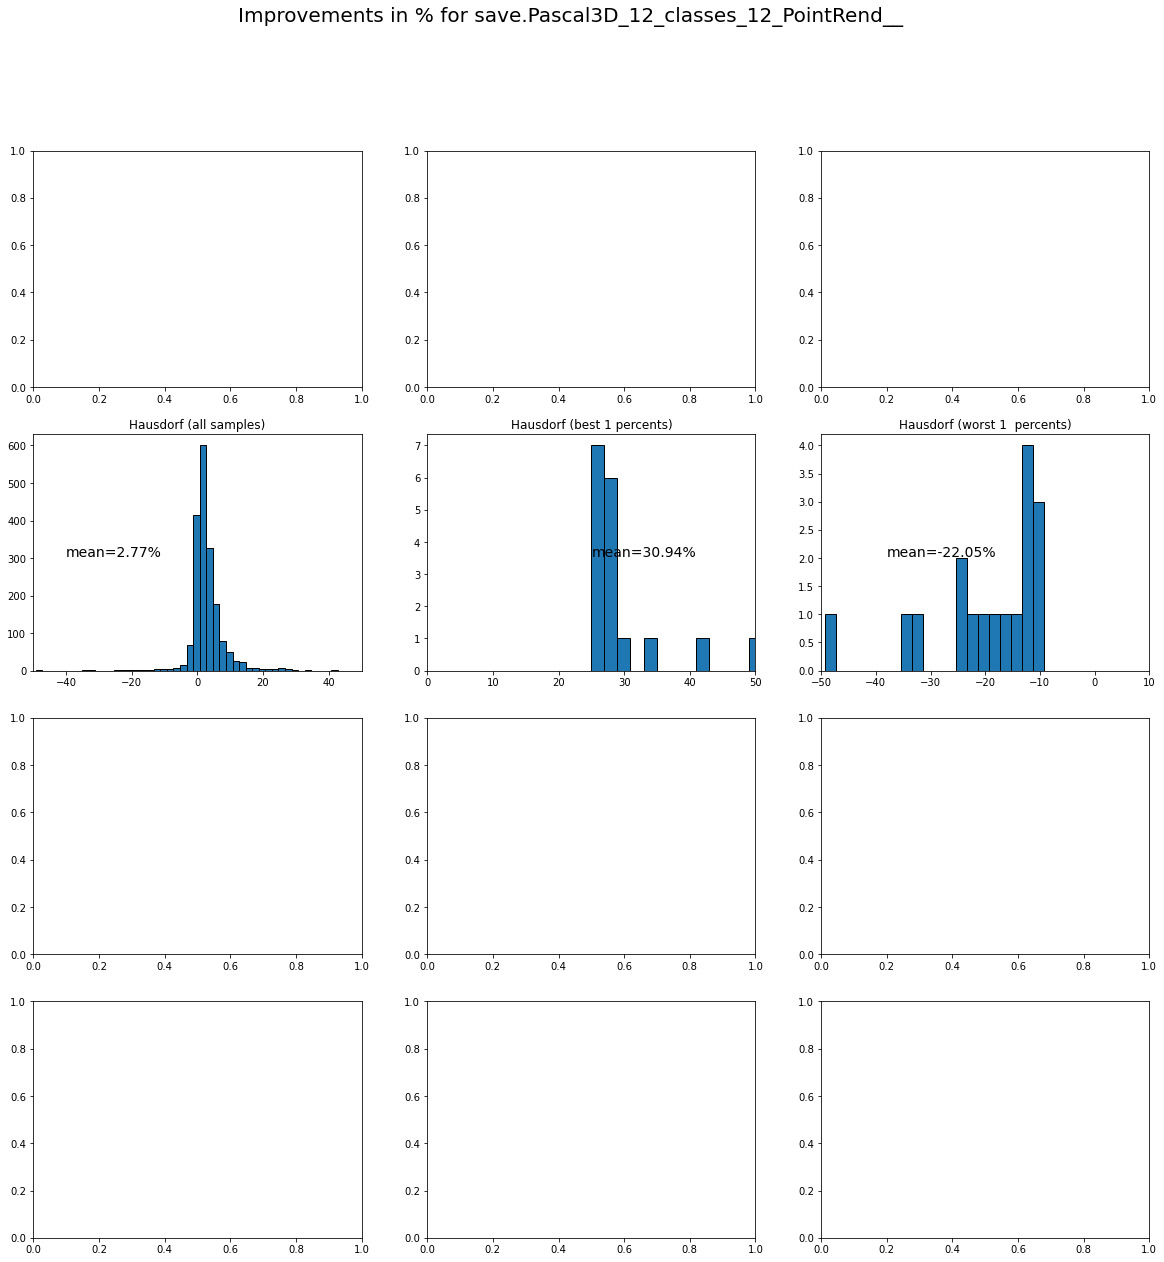

In [22]:
# main loop to get histograms and drawing 
from  auxilary.test_postprocessing import get_mesh_cad_file_pairs, SourceTargetMeshPipeline
shortenPath =  lambda path: '/'.join(path.split('/')[-3:-1]).replace('/', '.') #simple version of path to test name  
CAD_path   = "/home/ubuntu/research/datasets/Pascal3D+_release1.1/CAD_preprocessed_tri"
result_path_list = [ \
                    '../save/Pascal3D_12_classes_12_PointRend__/aeroplane-bicycle-boat-bottle-bus-car-chair-diningtable-motorbike-sofa-train-tvmonitor-qualitative', \
                    '../save/Pascal3D_12_classes_1_PointRend__/aeroplane-bicycle-boat-bottle-bus-car-chair-diningtable-motorbike-sofa-train-tvmonitor-qualitative', \
                    '../save/plane_8_MRCNN__/aeroplane-qualitative/', \
                    '../save/not_symmetric/car_10_MRCNN__/car-qualitative', \
                    '../save/plane_car_1_PointRend__/aeroplane-car-qualitative',\
                    '../save/plane_car_2_PointRend__/aeroplane-car-qualitative', \
                    '../save/bicycle_bus_car_bike_1_PointRend__/bicycle-bus-car-motorbike-qualitative',\
                    '../save/bicycle_bus_car_bike_4_PointRend__/bicycle-bus-car-motorbike-qualitative' \
                    ]   

test_name = [shortenPath(p) for p in result_path_list]
import pickle
resume_pkl= '../draft/estimatation_of_3D_metrics-full-100_voxel_without_rescaling.pkl'
with open(resume_pkl, 'rb') as handle:    experiment_data = pickle.load(handle)

# print(experiment_data.keys())
# print(experiment_data['reportSymmType'])
# print(experiment_data['reportSymm'])


reportOrig = experiment_data['reportOrig']
reportSymm = experiment_data['reportSymm']
metric_names = reportSymm.metric_names
reportImprovemetns = du.MetricReport(metric_names)

metric_num = len(reportSymm.metric_names)
#for ti in range(len(result_path_list)):
#V_symm = {}
V_meshes_worst = {}
metrics_worst  = {}
F_meshes_worst = {}
V_meshes_best  = {}
metrics_best   = {}
F_meshes_best  = {}


#3d configurations 
opt = gu.transformation_options(iter_num=10, sample_num = 2000, voxel_num =100,  enable_rescale = False, verbose =False)
opt.rewrite = False
#print(opt)
pipeline_opt = gu.pipeline_options(enable_icp=True)
pipeline_opt.IoU_3D_func  = gu.OneMinus3DIoU_fast
symmTypesDict             = {0:'orig',1:'l2r', 2:'r2l', 3:'cent'}
#print(pipeline_opt)


#for ti in [2]:
for ti in [0]:
    mesh_files, cad_files = get_mesh_cad_file_pairs([result_path_list[ti]], CAD_path)
    metrics_report     = reportOrig.metrics_list[ti]
    metric_symm_report = reportSymm.metrics_list[ti]
    Out(f'test number {ti}, number of samples = {metric_symm_report.shape}, number of meshes ={len(mesh_files)}')
    Out(f"  best    symmetrization =  {metric_symm_report.mean(axis=0)}")


    
    mesh_files = du.List(mesh_files)
    cad_files  = du.List(cad_files)


    #metrics_mean = metrics.mean(axis=0).tolist()
    improvment =  100*(metrics_report - metric_symm_report ) / metrics_report
    metrics_mean_report = metrics_report.mean(axis=0).tolist()
    mean_improvment =  (metrics_mean_report - metric_symm_report.mean(axis=0)) / metrics_mean_report
    reportImprovemetns.add_test(test_name[ti], np.array(improvment))

    Out(f"      mean improvements = {(100*mean_improvment,improvment.mean(axis=0))} %")

    fig, axs = plt.subplots(metric_num, 3, figsize=(20,20) )
    fig.suptitle(f'Improvements in % for {test_name[ti]} ', fontsize=20)
    #for name in reportSymm.metric_names:
    sample_num = metrics_report.shape[0]
    Vsym_meshes =[]
    Vcad_meshes =[]
    Fcad_meshes =[]
    
    symmetry_data = np.load( result_path_list[ti] + '/shape_symmetries.npy', allow_pickle = True).item() #symmetry data is the same for all classes 
    opt.symmetry_data = symmetry_data
    metric_num = len(reportSymm.metric_names)
    metic_names = ['1-3D_IoU', 'Hausdorff', 'mean-max', 'mean-mean']
    #for mi in range(metric_num): # <-- uncomment it to get all histograms for all  metrics 
    for mi in [1]: #histograms for hausdorff metric only
        name  =reportSymm.metric_names[mi]
        data = improvment[:,mi] if mi  else -improvment[:,mi] # 3D IoU goes in differnt direction
        Range = [-50, 50]

        w=2
        #histogram 
        axs[mi,0].hist(data, edgecolor='black', bins=np.arange(min(data), max(data) + w, w)) 
        axs[mi,0].title.set_text(f'{name} (all samples)')
        axs[mi,0].set_xlim(Range)
        axs[mi,0].text(0.1, 0.5, f'mean={data.mean():.2f}%', horizontalalignment='left',  verticalalignment='center', transform =  axs[mi,0].transAxes, fontsize=14)

        
        #computing outlier sampled w.r.t metric "mi"
        outlier_percent = 1
        outlier_num = int(outlier_percent/100*sample_num)
        
        sorted_indices   = np.argsort(data)
        worst_indices    = sorted_indices[:outlier_num]
        data_worst       = data[ worst_indices ]
        worst_mesh_files = mesh_files[worst_indices]
        worst_cad_files  = cad_files[worst_indices]
        

        best_indices     = sorted_indices[-outlier_num:]
        data_best        = data[best_indices]
        best_mesh_files  = mesh_files[best_indices]
        best_cad_files   = cad_files[best_indices]
       
      

        _, F_meshes_worst    = tp.load_meshes_from_files(worst_mesh_files)
        Vcad_meshes_worst, Fcad_meshes_worst = tp.load_meshes_from_files(worst_cad_files)

        _, F_meshes_best    = tp.load_meshes_from_files(best_mesh_files)
        Vcad_meshes_best, Fcad_meshes_best = tp.load_meshes_from_files(best_cad_files)

        metrics_worst ={}
        metrics_best  ={}
        for symm_type, symm_name in symmTypesDict.items():
            pipeline_opt.symmetrization_type = symm_type
            metrics_worst[symm_name], V_meshes_worst[symm_name] = tp.compute_3d_metrics(worst_mesh_files, worst_cad_files, opt, pipeline_opt)
            metrics_best[symm_name],  V_meshes_best[symm_name]  = tp.compute_3d_metrics(best_mesh_files,  best_cad_files, opt, pipeline_opt)

     
        axs[mi,1].hist(data_best, edgecolor='black', bins=np.arange(min(data_best), max(data_best) + w, w)) 
        axs[mi,1].title.set_text(f'{name} (best {outlier_percent} percents)')
        axs[mi,1].set_xlim([0,Range[1]])
        axs[mi,1].text(0.5, 0.5, f'mean={data_best.mean():.2f}%', horizontalalignment='left',  verticalalignment='center', transform =  axs[mi,1].transAxes, fontsize=14)

        axs[mi,2].hist(data_worst, edgecolor='black', bins=np.arange(min(data_worst), max(data_worst) + w, w)) 
        axs[mi,2].title.set_text(f'{name} (worst {outlier_percent}  percents)')
        axs[mi,2].set_xlim([Range[0], 10])
        axs[mi,2].text(0.2, 0.5, f'mean={data_worst.mean():.2f}%', horizontalalignment='left',  verticalalignment='center', transform =  axs[mi,2].transAxes, fontsize=14)
        fig_file = f'../debug/plots/{test_name[ti]}.png'
        fig.savefig(fig_file)
        print(f'writting {fig_file}')
        for metrics, ii, outlier_type in [(metrics_worst,0,'worst'), (metrics_best,-1,'best')]: 

            metrics_symm     = np.stack(list(metrics.values()) ,axis=2) #stack metrics from all k symmetrization into  N*K matrix
            metrics['best']       = metrics_symm.min(axis=-1)
            metrics['best_type']  = np.argmin(metrics_symm,axis=-1)
            metrics['worst']      = metrics_symm.max(axis=-1)
            metrics['worst_type'] = np.argmax(metrics_symm,axis=-1)
            


            Out(f'Analyse {outlier_type} cases for metric {metic_names[mi]} ')
            symmNames = [*symmTypesDict.values()]#names of differnet symmetrization types 

            metric_table =  tabulate( [ ['Type']  + metic_names] + \
                                    [[name] +   metrics[name][ii].tolist() for name in symmNames], \
                                    headers="firstrow" )

            print(metric_table)
            Out('Mesh-to CAD distance Improvments in %')

            metric_improvment =  tabulate( [ ['Type'] + metic_names ] + \
                                        [ [name] + (100*(metrics['orig'][ii]- metrics[name][ii])/metrics['orig'][ii]).tolist()  for name in symmNames[1:] ], \
                                        headers="firstrow" )
            print(metric_improvment)
        
        # =================================================================
        #           3D plot of outliers with highlighet points 

        ii = 0
        #symm_type_name = 'r2l'
        worst_symm_type_index =  metrics_worst['worst_type'][ii,mi]
        worst_symm_type_name = list(symmTypesDict.values())[worst_symm_type_index]
        mu.Out(f'visualizing the worst Husdorff sample for symmetrization of  type = {worst_symm_type_name}')
        wF      = F_meshes_worst[ii]
        wF_cad  = Fcad_meshes_worst[ii]
        wV      = V_meshes_worst['orig'][ii]
        wV_sym  = V_meshes_worst[worst_symm_type_name][ii]
        wV_cad =  Vcad_meshes_worst[ii]
        Visualize_Hausdorff_Outlier(wV,wF, wV_sym, wV_cad,wF_cad, viewpoints = [ (np.array([0,1,0]), math.pi ), (np.array([0,1,0]), -0.5*math.pi ) ])

        ii =-1
        best_symm_type_index =  metrics_best['best_type'][ii,mi]
        best_symm_type_name = list(symmTypesDict.values())[best_symm_type_index]
        mu.Out(f'visualizing the best Husdorff sample for symmetrization of  type = {best_symm_type_name}')
        bF      = F_meshes_best[ii]
        bF_cad  = Fcad_meshes_best[ii]
        bV      = V_meshes_best['orig'][ii]
        bV_sym  = V_meshes_best[best_symm_type_name][ii]
        bV_cad =  Vcad_meshes_best[ii]
        #Visualize_Hausdorff_Outlier(bV,bF, bV_sym, bV_cad,bF_cad, viewpoints = [ (np.array([0,1,0]), math.pi ), (np.array([0,1,0]), 0.5*math.pi ) ])
        Visualize_Hausdorff_Outlier(bV,bF, bV_sym, bV_cad,bF_cad, viewpoints = [ (np.array([0,1,0]), 0 ), (np.array([1,0,0]), 0.5*math.pi ) ])

## For debuging of OLD version of    Hasudorff distance visualization   (mesh-CAD distance vs symmetrized_mesh-CAD distance)
### Run it after running the cell of the  OLD analysis

* -W- Do not  rely on the bellow code because there are may be  bugs !!! (previous cells for visual analysis were validated, this one wasn't !) 


In [27]:
# Pick up a mesh for analysis and report its statistics 
Out('Analyse worst cases')
ii = 0
# V_cent = V_cent_meshes[ii]
# V_l2r  = V_l2r_meshes[ii]
# V_r2l  = V_r2l_meshes[ii]
# V      = V_meshes[ii]
# F      = F_meshes[ii]
Vcad_meshes = Vcad_meshes_worst
Fcad_meshes = Fcad_meshes_worst

V_cent = V_meshes_worst['cent'][ii]
V_l2r  = V_meshes_worst['l2r'][ii]
V_r2l  = V_meshes_worst['r2l'][ii]
V      = V_meshes_worst['orig'][ii]
F      = F_meshes_worst[ii]

metrics      = metrics_worst['orig']
metrics_l2r  = metrics_worst['l2r']
metrics_r2l  = metrics_worst['r2l']
metrics_cent = metrics_worst['cent']

orig_col = [0.85,0.85,0.85]
symm_col = [0,1,0]
cad_col = [1,1,0]
V_cad = Vcad_meshes[ii]
F_cad = Fcad_meshes[ii]
print(metrics[ii].shape)
Out('Mesh-to CAD distances')
metric_table =  tabulate( [ ['Type','1-3D_IoU', 'Hausdorff', 'mean-max', 'mean-mean' ], \
                            ['Orig']  +  metrics[ii].tolist(), \
                            ['L2R']   +  metrics_l2r[ii].tolist(),\
                            ['R2L']   +  metrics_r2l[ii].tolist(),\
                            ['Cent']  +  metrics_cent[ii].tolist(),\
                          ], headers="firstrow" )

print(metric_table)
Out('Mesh-to CAD distance Improvments in %')
metric_improvment =  tabulate( [ ['Type','1-3D_IoU', 'Hausdorff', 'mean-max', 'mean-mean' ], \
                            ['L2R']   +  (100*(metrics[ii]-  metrics_l2r[ii])/metrics[ii]).tolist(),\
                            ['R2L']   +  (100*(metrics[ii]-  metrics_r2l[ii])/metrics[ii]).tolist(),\
                            ['Cent']  +  (100*(metrics[ii]- metrics_cent[ii])/metrics[ii]).tolist(),\
                          ], headers="firstrow" )
print(metric_improvment)

### Analyse worst cases

(4,)


### Mesh-to CAD distances

Type      1-3D_IoU    Hausdorff    mean-max    mean-mean
------  ----------  -----------  ----------  -----------
Orig      0.316498     0.255819   0.090559     0.0719177
L2R       0.313499     0.432366   0.0933427    0.0669021
R2L       0.299514     0.417792   0.0946523    0.0687303
Cent      0.308318     0.432802   0.0946789    0.0676287


### Mesh-to CAD distance Improvments in %

Type      1-3D_IoU    Hausdorff    mean-max    mean-mean
------  ----------  -----------  ----------  -----------
L2R       0.947735     -69.0128    -3.07388      6.97408
R2L       5.36639      -63.3159    -4.52003      4.4319
Cent      2.58448      -69.183     -4.54937      5.96367


## Visualize reconstructed meshes and their symmetrization VS CADs

In [30]:
V_right = symmetry_data['V_right']
V_opposite = symmetry_data['V_opposite']
#recompute relative symmetry errors 
LR_diff = np.linalg.norm(V[V_right,:] - gu.reflectX(V[V_opposite[V_right],:]), axis=1)
#shape_scale = V[:,0].max() - V[:,0].min()
#LR_diff = LR_diff_unscaled/shape_scale
vr_max= V_right[LR_diff.argmax()]
vl_max= V_opposite[vr_max]
sV, sF = get_sphere(V) 
lcol = [1,0,0]
rcol = [0,0,1]
pcol = np.array([lcol,rcol])
maxCol=[1,0,0]


mesh2CAD =  igl.point_mesh_squared_distance(V, V_cad, F_cad)
mesh2CAD_imax =  mesh2CAD[0].argmax()
V_max = V[mesh2CAD_imax,:]
V_max = np.row_stack((V_max,V_max))

Vcad_max = np.array(mesh2CAD[2][mesh2CAD_imax])
Vcad_max = np.row_stack((Vcad_max,Vcad_max))

highlight_max_dist = False
shading = dict(wireframe=True, line_color= [0.1,0.1,0.1], width=1000, height=600, wire_width=0.01, flat=True, line_width=0.01)
shadings = [shading, shading, shading, shading.copy()]
shadings[-1]['wireframe'] = False

if highlight_max_dist:
  Out('reconstructed mesh vs CAD (highlighted pairs of largest distance)')
  mu.DrawMeshes(None, [ [V,     F,     orig_col, V_max, lcol ],\
                        [V_cad, F_cad, cad_col,  Vcad_max ,rcol], \
                        [V,     F,     orig_col+[0.6], V_max, lcol ], [V_cad, F_cad, cad_col+[0.6], Vcad_max ,rcol], \
                      ], shifts =[(1.5,0,0), (1.5,0,0), (0,0,0), (0,0,0)],mesh_shading = shadings,  point_shading=dict(point_size= 0.2))
  
  mu.DrawMeshes(None, [ [V_l2r,     F,     symm_col, V_max, lcol ],\
                        [V_cad, F_cad, cad_col,  Vcad_max ,rcol], \
                        [V_l2r,     F,     symm_col+[0.6], V_max, lcol ], [V_cad, F_cad, cad_col+[0.6], Vcad_max ,rcol], \
                      ], shifts =[(1.5,0,0), (1.5,0,0), (0,0,0), (0,0,0)],mesh_shading = shadings,  point_shading=dict(point_size= 0.2))

else:
  Out('reconstructed mesh vs CAD ')
  mu.DrawMeshes(None, [ [V,     F,     orig_col ],\
                        [V_cad, F_cad, cad_col], \
                        [V,     F,     orig_col+[0.6]], [V_cad, F_cad, cad_col+[0.6]], \
                      ], shifts =[(1.5,0,0), (1.5,0,0), (0,0,0), (0,0,0)],mesh_shading = shadings,  point_shading=dict(point_size= 0.2))
  mu.DrawMeshes(None, [ [V_l2r,     F,     symm_col ],\
                        [V_cad, F_cad, cad_col], \
                        [V_l2r,     F,     symm_col+[0.6]], [V_cad, F_cad, cad_col+[0.6]], \
                      ], shifts =[(1.5,0,0), (1.5,0,0), (0,0,0), (0,0,0)],mesh_shading = shadings,  point_shading=dict(point_size= 0.2))


Out('Point pair of the highest geometric symmetry error')
shading = dict(wireframe=True, line_color= [0.1,0.1,0.1], width=1000, height=600, wire_width=0.01, flat=True, line_width=0.01)
shadings = [shading, shading, shading, shading.copy()]
shadings[-1]['wireframe'] = False
mesh2_l2r      =  igl.point_mesh_squared_distance(V, V_l2r, F)
mesh2_l2r_imax =  mesh2_l2r[0].argmax()
Vorig_max = V[mesh2_l2r_imax,:]
Vorig_max = np.row_stack((Vorig_max,Vorig_max))

Vl2r_max = np.array(mesh2_l2r[2][mesh2_l2r_imax])
Vl2r_max = np.row_stack((Vl2r_max,Vl2r_max))

Out('Reconstructed mesh (grey) vs l2r symmetrization (green)')
mu.DrawMeshes(None, [ \
                      [V,    F, orig_col],\
                      [V_l2r,F, symm_col], \
                      [V,    F, orig_col+[0.6]], [V_l2r,F, symm_col+[0.6] ], \
                    ], shifts =[(1.5,0,0),(1.5,0,0), (0,0,0), (0,0,0)],mesh_shading = shadings,  point_shading=dict(point_size= 0.15))


Out('Vertex pair of the highest deformation symmetry error')
shading = dict(wireframe=True, line_color= [0.1,0.1,0.1], width=1000, height=600, wire_width=0.01, flat=True, line_width=0.01)
shadings = [shading,shading,shading, shading.copy(), shading.copy()]
shadings[-1]['wireframe'] = False
shadings[-2]['wireframe'] = False
mu.DrawMeshes(None, [ [sV,  sF, orig_col, [vr_max, vl_max], pcol], \
                      [V,    F, orig_col, [vr_max, vl_max], pcol],\
                      [V_l2r,F, symm_col, [vr_max, vl_max], pcol], \
                      [V,    F, orig_col, [vr_max, vl_max], pcol], [V_l2r,F, symm_col, [vr_max, vl_max], pcol], \
                    ], shifts =[(1.5,0,0),(1.5,0,0), (1.5,0,0), (0,0,0), (0,0,0)],mesh_shading = shadings,  point_shading=dict(point_size= 0.15))

resolution level=4


### reconstructed mesh vs CAD 

Renderer(camera=PerspectiveCamera(aspect=1.6666666666666667, children=(DirectionalLight(color='white', intensi…

Renderer(camera=PerspectiveCamera(aspect=1.6666666666666667, children=(DirectionalLight(color='white', intensi…

### Point pair of the highest geometric symmetry error

### Reconstructed mesh (grey) vs l2r symmetrization (green)

Renderer(camera=PerspectiveCamera(aspect=1.6666666666666667, children=(DirectionalLight(color='white', intensi…

### Vertex pair of the highest deformation symmetry error

Renderer(camera=PerspectiveCamera(aspect=1.6666666666666667, children=(DirectionalLight(color='white', intensi…

## Visualize  meshe-to-CAD distances 
* for rendering with small 'fov' scroll it down to see meshes from a distant camera view 

### 3D plot of distances from CAD to the recunstructed mesh and its symmetrizations

###  From left-to-right: orig_dist_color, l2r_dist_color, r2l_dist_color, cent_dist_color 

Renderer(camera=PerspectiveCamera(aspect=2.0, children=(DirectionalLight(color='white', intensity=0.6, positio…

drawing color bar


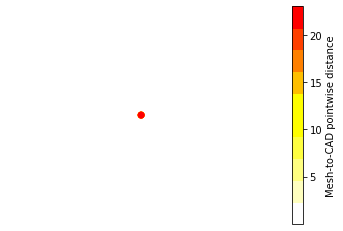

In [31]:
mesh_l2r2CAD  =  igl.point_mesh_squared_distance(V_l2r, V_cad, F_cad)[0]
mesh_r2l2CAD  =  igl.point_mesh_squared_distance(V_r2l, V_cad, F_cad)[0]
mesh_cent2CAD =  igl.point_mesh_squared_distance(V_cent, V_cad, F_cad)[0]
mesh_orig2CAD = mesh2CAD[0]
colMap = mu.ColorMapGradient([(1,1,1),(1,1,0),(1,0,0)], 5)
color_np = colMap.color_array
nbins    = colMap.nbins 

colMap.set_bins([mesh_l2r2CAD, mesh_r2l2CAD, mesh_cent2CAD, mesh_orig2CAD])
(orig_dist_color,l2r_dist_color,r2l_dist_color,cent_dist_color) = tuple(colMap.colorize([mesh_l2r2CAD, mesh_r2l2CAD, mesh_cent2CAD, mesh_orig2CAD], common_range=True))
shading = dict(wireframe=False, line_color= [0.1,0.1,0.1], width=1200, height=600, wire_width=0.01, flat=False, line_width=0.01, smooth=True,\
               fov=1, scale=30) #fov=0 => orthograhic projection (moving forward will not decreae size, need to rescal meshes, or approximate Orthogrpahic proj. by small fov)
#For small shading['fov'] scroll down to see 3D plot !!!!
Out("3D plot of distances from CAD to the recunstructed mesh and its symmetrizations")
Out(" From left-to-right: orig_dist_color, l2r_dist_color, r2l_dist_color, cent_dist_color ")
mu.DrawMeshes(None, [\
                     [V,      F, orig_dist_color],\
                     [V_l2r,  F, l2r_dist_color], \
                     [V_r2l,  F, r2l_dist_color], \
                     [V_cent, F, cent_dist_color], \
                    ],   shifts =[(1.5,0,0),(1.5,0,0), (1.5,0,0), (0,0,0)],mesh_shading = shading)

print('drawing color bar')
colMap.draw_color_bar(label='Mesh-to-CAD pointwise distance')



## Visualize colored geometric symmetry distances 

### From left-ro-right: 3D pot of deform_symm_error_color, geom_symm_error_color 

Renderer(camera=PerspectiveCamera(aspect=2.0, children=(DirectionalLight(color='white', intensity=0.6, positio…

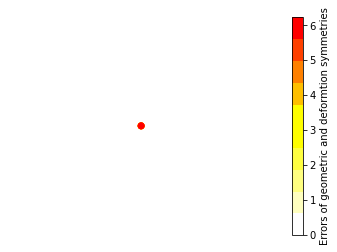

In [33]:
deform_symm_error         = np.linalg.norm(V - gu.reflectX( V[V_opposite,:]), axis=1)
#geom_symm_error           = igl.point_mesh_squared_distance(V_l2r, V_r2l, F)[0] 
geom_symm_error =  np.zeros(V.shape[0])
V_left = V_opposite[V_right]
geom_symm_error[V_right]    = igl.point_mesh_squared_distance(V, V_l2r, F)[0][V_right] 
geom_symm_error[V_left]     = igl.point_mesh_squared_distance(V, V_r2l, F)[0][V_left] 


colMap = mu.ColorMapGradient([(1,1,1),(1,1,0),(1,0,0)], 5)
color_np = colMap.color_array
nbins    = colMap.nbins 

colMap.set_bins([mesh_l2r2CAD, mesh_r2l2CAD, mesh_cent2CAD, mesh_orig2CAD])
(deform_symm_error_color,geom_symm_error_color) = tuple(colMap.colorize([deform_symm_error, geom_symm_error], common_range=False))
shading = dict(wireframe=False, line_color= [0.1,0.1,0.1], width=1200, height=600, wire_width=0.01, flat=False, line_width=0.01, smooth=True,\
               fov=1, scale=30) #fov=0 => orthograhic projection (moving forward will not decreae size, need to rescal meshes, or approximate Orthogrpahic proj. by small fov)
Out("From left-ro-right: 3D pot of deform_symm_error_color, geom_symm_error_color ")
mu.DrawMeshes(None, [\
                     [V,      F, deform_symm_error_color],\
                     [V,      F, geom_symm_error_color],\
                    ],   shifts =[(1.5,0,0),(1.5,0,0), (1.5,0,0), (0,0,0)],mesh_shading = shading)

colMap.draw_color_bar(label='Errors of geometric and deformtion symmetries')

Renderer(camera=PerspectiveCamera(aspect=2.6666666666666665, children=(DirectionalLight(color='white', intensi…

drawing color bar


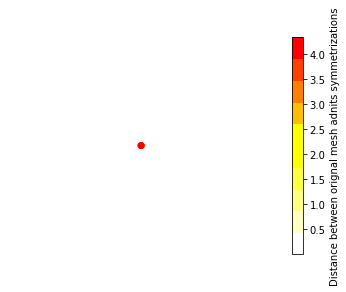

In [34]:
orig2l2r_dist    = igl.point_mesh_squared_distance(V, V_l2r, F)[0] 
orig2r2l_dist    = igl.point_mesh_squared_distance(V, V_r2l, F)[0]


colMap = mu.ColorMapGradient([(1,1,1),(1,1,0),(1,0,0)], 5)
color_np = colMap.color_array
nbins    = colMap.nbins 

colMap.set_bins([mesh_l2r2CAD, mesh_r2l2CAD, mesh_cent2CAD, mesh_orig2CAD])
(orig2l2r_dist_color, orig2r2l_dist_color) = tuple(colMap.colorize([orig2l2r_dist,orig2r2l_dist], common_range=False))
shading = dict(wireframe=False, line_color= [0.1,0.1,0.1], width=1600, height=600, wire_width=0.01, flat=False, line_width=0.01, smooth=True,\
               fov=1, scale=30) #fov=0 => orthograhic projection (moving forward will not decreae size, need to rescal meshes, or approximate Orthogrpahic proj. by small fov)

shading1 = shading.copy()
shading1['wireframe'] = True
symm_l2r_col = [0,1,0, 0.6]
symm_r2l_col = [0,0,1, 0.6]
shadings = [shading1,shading1, shading, shading1,shading1,  shading]



mu.DrawMeshes(None, [ [V,    F, orig_col ],\
                      [V_l2r,F, symm_l2r_col ], \
                      [V,    F, orig2l2r_dist_color], \
                      \
                      [V,    F, orig_col ],\
                      [V_r2l,F, symm_r2l_col ], \
                      [V,    F, symm_l2r_col], \
                    ], shifts =[(0,0,0),(1.5,0,0), (2,0,0),(0,0,0),(1.5,0,0),(0,0,0)],mesh_shading = shadings)


print('drawing color bar')
colMap.draw_color_bar(label='Distance between orignal mesh adnits symmetrizations')